In [376]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm as tqdm 
import pandas as pd

import matplotlib.pyplot as plt

In [427]:
## 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (13,7)

## Data

In [377]:
#데이터 로딩
train_X = np.load(f'data/RNN/train_X.npy')
train_y = np.load(f'data/RNN/train_y.npy')
valid_X = np.load(f'data/RNN/valid_X.npy')
valid_y = np.load(f'data/RNN/valid_y.npy')
test_X = np.load(f'data/RNN/test_X.npy')
test_y = np.load(f'data/RNN/test_y.npy')

## 모든자산군에 날짜는 같지만.. 
train_ans = pd.read_csv(f'data/RNN/train_ans.csv', index_col=0)
valid_ans = pd.read_csv(f'data/RNN/valid_ans.csv', index_col=0)
test_ans = pd.read_csv(f'data/RNN/test_ans.csv', index_col=0)

## Model

In [378]:
#GRU 모델
class scorer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(scorer, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.GRU(input_dim, hidden_dim, bidirectional=False)
        self.l1 = nn.Linear(hidden_dim, hidden_dim+int(hidden_dim/2))
        self.rel = nn.LeakyReLU()
        self.dl1 = nn.Dropout(p=.5)
        self.l2 = nn.Linear(hidden_dim+int(hidden_dim/2),hidden_dim)
        self.l3 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = x.permute(1,0,2)
        out,_ = self.rnn(x)
        mr = out[-1]
        out = self.l1(mr)
        out = self.rel(out)
        out = self.dl1(out)
        out = self.l2(out)
        out = self.l3(out)
        ## out = torch.sigmoid(out)
        
        return out.flatten()

In [379]:
#데이터 클래스 정의
class Dataset(Dataset):
    def __init__(self, X, y):

        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()

    def __getitem__(self, i):
        return (self.X[i], self.y[i])

    def __len__(self):
        return (len(self.y))

In [398]:
#훈련 하이퍼 파라미터
batch_size = 32
lr = .001
num_epoch = 1000
log_interval = 100
loss_fn = nn.MSELoss()
model_name = 'scoring.pth'
sc_hidden_dim = 1000

In [399]:
#GRU모델
model = scorer(train_X.shape[2], sc_hidden_dim).cuda()
## optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0) ## lr 스케줄러

## Dataset
traindataset = Dataset(train_X,train_y)
validataset = Dataset(valid_X,valid_y)
testdataset = Dataset(test_X,test_y)
train_dataloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size)
valid_dataloader = torch.utils.data.DataLoader(validataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size)

In [400]:
print("Train 시작!")
trl = []
vll = []
#training scheme
for i in range(num_epoch):
    train_loss = 0
    valid_loss = 0
    model.train()
    #### Training
    for batch_id, (X,y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        out = model(X.cuda())

        loss = loss_fn(out,y.cuda())

        loss.backward()
        optimizer.step()

        lossavg = (loss/len(y)).data.cpu().numpy()
        train_loss += lossavg

        if batch_id % log_interval == 0:
            print('Epoch: ',i+1,' Batch ID: ',batch_id,' Train Loss: ',train_loss / (batch_id+1))
        trl.append(train_loss / (batch_id+1))
    scheduler.step()


    #### Evaluation on Validset
    model.eval()
    for batch_id, (X,y) in enumerate(valid_dataloader):
        out = model(X.cuda())

        loss = loss_fn(out,y.cuda())

        lossavg = (loss/len(y)).data.cpu().numpy()
        valid_loss += lossavg
    print('epoch: ',i+1,' Valid Loss: ',valid_loss / (batch_id+1))
    if len(vll) > 0:
        if max(vll) < valid_loss.item():
            torch.save(model.state_dict(),model_name)
    else:
        torch.save(model.state_dict(),model_name)
    vll.append((valid_loss/ (batch_id+1)))

Train 시작!
Epoch:  1  Batch ID:  0  Train Loss:  12.370124816894531
Epoch:  1  Batch ID:  100  Train Loss:  4.982519781825566
Epoch:  1  Batch ID:  200  Train Loss:  4.209091232857894
Epoch:  1  Batch ID:  300  Train Loss:  3.1429090877605037
epoch:  1  Valid Loss:  12.3674858645695
Epoch:  2  Batch ID:  0  Train Loss:  12.617494583129883
Epoch:  2  Batch ID:  100  Train Loss:  4.9634095400866896
Epoch:  2  Batch ID:  200  Train Loss:  4.298083177030976
Epoch:  2  Batch ID:  300  Train Loss:  3.2164492080873033
epoch:  2  Valid Loss:  12.671702367794223
Epoch:  3  Batch ID:  0  Train Loss:  12.667952537536621
Epoch:  3  Batch ID:  100  Train Loss:  4.961135673345906
Epoch:  3  Batch ID:  200  Train Loss:  4.229636373952847
Epoch:  3  Batch ID:  300  Train Loss:  3.15970500749211
epoch:  3  Valid Loss:  12.264904874272462
Epoch:  4  Batch ID:  0  Train Loss:  12.59608268737793
Epoch:  4  Batch ID:  100  Train Loss:  4.866941409535928
Epoch:  4  Batch ID:  200  Train Loss:  4.197105358414

Epoch:  30  Batch ID:  300  Train Loss:  2.5857113910176825
epoch:  30  Valid Loss:  11.186620177001489
Epoch:  31  Batch ID:  0  Train Loss:  12.78024673461914
Epoch:  31  Batch ID:  100  Train Loss:  4.267609966273355
Epoch:  31  Batch ID:  200  Train Loss:  3.5428177597955686
Epoch:  31  Batch ID:  300  Train Loss:  2.6929442116687463
epoch:  31  Valid Loss:  11.013515649626894
Epoch:  32  Batch ID:  0  Train Loss:  11.85361099243164
Epoch:  32  Batch ID:  100  Train Loss:  4.379094940010864
Epoch:  32  Batch ID:  200  Train Loss:  3.5996304507279278
Epoch:  32  Batch ID:  300  Train Loss:  2.7043477067866197
epoch:  32  Valid Loss:  11.232803260989305
Epoch:  33  Batch ID:  0  Train Loss:  12.620976448059082
Epoch:  33  Batch ID:  100  Train Loss:  4.409193174083634
Epoch:  33  Batch ID:  200  Train Loss:  3.6083769626285305
Epoch:  33  Batch ID:  300  Train Loss:  2.708292824930923
epoch:  33  Valid Loss:  11.532808696642155
Epoch:  34  Batch ID:  0  Train Loss:  13.30008411407470

Epoch:  60  Batch ID:  100  Train Loss:  3.91940310626927
Epoch:  60  Batch ID:  200  Train Loss:  3.1998404638832483
Epoch:  60  Batch ID:  300  Train Loss:  2.3972086325980895
epoch:  60  Valid Loss:  10.814287203695716
Epoch:  61  Batch ID:  0  Train Loss:  11.842711448669434
Epoch:  61  Batch ID:  100  Train Loss:  3.8449788170285744
Epoch:  61  Batch ID:  200  Train Loss:  3.1747781368926984
Epoch:  61  Batch ID:  300  Train Loss:  2.3777359977760586
epoch:  61  Valid Loss:  10.814287203695716
Epoch:  62  Batch ID:  0  Train Loss:  11.681600570678711
Epoch:  62  Batch ID:  100  Train Loss:  3.8675810845181493
Epoch:  62  Batch ID:  200  Train Loss:  3.177461997230551
Epoch:  62  Batch ID:  300  Train Loss:  2.378861686394262
epoch:  62  Valid Loss:  10.81937684256856
Epoch:  63  Batch ID:  0  Train Loss:  11.865535736083984
Epoch:  63  Batch ID:  100  Train Loss:  3.9030136666675603
Epoch:  63  Batch ID:  200  Train Loss:  3.2023045830613937
Epoch:  63  Batch ID:  300  Train Loss:

Epoch:  89  Batch ID:  300  Train Loss:  2.7022400113732314
epoch:  89  Valid Loss:  11.19347063855427
Epoch:  90  Batch ID:  0  Train Loss:  12.051236152648926
Epoch:  90  Batch ID:  100  Train Loss:  4.27841601277342
Epoch:  90  Batch ID:  200  Train Loss:  3.508445896986705
Epoch:  90  Batch ID:  300  Train Loss:  2.621886379496996
epoch:  90  Valid Loss:  11.478734654042778
Epoch:  91  Batch ID:  0  Train Loss:  12.632116317749023
Epoch:  91  Batch ID:  100  Train Loss:  4.312983211609397
Epoch:  91  Batch ID:  200  Train Loss:  3.5428226059349024
Epoch:  91  Batch ID:  300  Train Loss:  2.6544077578078076
epoch:  91  Valid Loss:  11.143356831771571
Epoch:  92  Batch ID:  0  Train Loss:  11.63143539428711
Epoch:  92  Batch ID:  100  Train Loss:  4.271775757912362
Epoch:  92  Batch ID:  200  Train Loss:  3.444285110899465
Epoch:  92  Batch ID:  300  Train Loss:  2.586253033919984
epoch:  92  Valid Loss:  11.09812417931673
Epoch:  93  Batch ID:  0  Train Loss:  12.562152862548828
Epo

Epoch:  118  Batch ID:  300  Train Loss:  2.641501368181254
epoch:  118  Valid Loss:  11.525066755312245
Epoch:  119  Batch ID:  0  Train Loss:  12.031390190124512
Epoch:  119  Batch ID:  100  Train Loss:  4.337800405403175
Epoch:  119  Batch ID:  200  Train Loss:  3.524802557790457
Epoch:  119  Batch ID:  300  Train Loss:  2.6608922126334766
epoch:  119  Valid Loss:  11.443309491145902
Epoch:  120  Batch ID:  0  Train Loss:  12.784462928771973
Epoch:  120  Batch ID:  100  Train Loss:  4.397715117081558
Epoch:  120  Batch ID:  200  Train Loss:  3.590001760578867
Epoch:  120  Batch ID:  300  Train Loss:  2.6828489450372732
epoch:  120  Valid Loss:  11.474235572175282
Epoch:  121  Batch ID:  0  Train Loss:  12.118500709533691
Epoch:  121  Batch ID:  100  Train Loss:  4.442931221853389
Epoch:  121  Batch ID:  200  Train Loss:  3.6637835839198005
Epoch:  121  Batch ID:  300  Train Loss:  2.7573977307821824
epoch:  121  Valid Loss:  11.579355537600634
Epoch:  122  Batch ID:  0  Train Loss: 

Epoch:  147  Batch ID:  200  Train Loss:  3.1565140001661147
Epoch:  147  Batch ID:  300  Train Loss:  2.378175364825813
epoch:  147  Valid Loss:  10.896848474188548
Epoch:  148  Batch ID:  0  Train Loss:  12.158443450927734
Epoch:  148  Batch ID:  100  Train Loss:  3.9889214274906877
Epoch:  148  Batch ID:  200  Train Loss:  3.2141092427037843
Epoch:  148  Batch ID:  300  Train Loss:  2.4237640239669633
epoch:  148  Valid Loss:  10.814227641064946
Epoch:  149  Batch ID:  0  Train Loss:  11.893537521362305
Epoch:  149  Batch ID:  100  Train Loss:  4.021845564983859
Epoch:  149  Batch ID:  200  Train Loss:  3.233513083327469
Epoch:  149  Batch ID:  300  Train Loss:  2.4256769277378174
epoch:  149  Valid Loss:  11.049287644973615
Epoch:  150  Batch ID:  0  Train Loss:  12.026768684387207
Epoch:  150  Batch ID:  100  Train Loss:  4.077126253359388
Epoch:  150  Batch ID:  200  Train Loss:  3.265234933711996
Epoch:  150  Batch ID:  300  Train Loss:  2.454949817338655
epoch:  150  Valid Loss

Epoch:  176  Batch ID:  100  Train Loss:  3.9725711363376957
Epoch:  176  Batch ID:  200  Train Loss:  3.1536396623250855
Epoch:  176  Batch ID:  300  Train Loss:  2.35862399457004
epoch:  176  Valid Loss:  10.852992782214793
Epoch:  177  Batch ID:  0  Train Loss:  11.90751838684082
Epoch:  177  Batch ID:  100  Train Loss:  3.9354594821977145
Epoch:  177  Batch ID:  200  Train Loss:  3.0986274073076485
Epoch:  177  Batch ID:  300  Train Loss:  2.3200755465862364
epoch:  177  Valid Loss:  10.775276074903767
Epoch:  178  Batch ID:  0  Train Loss:  11.719963073730469
Epoch:  178  Batch ID:  100  Train Loss:  3.914716838610054
Epoch:  178  Batch ID:  200  Train Loss:  3.075763159278613
Epoch:  178  Batch ID:  300  Train Loss:  2.3086651428989398
epoch:  178  Valid Loss:  10.772141543248805
Epoch:  179  Batch ID:  0  Train Loss:  11.793683052062988
Epoch:  179  Batch ID:  100  Train Loss:  3.860546832037444
Epoch:  179  Batch ID:  200  Train Loss:  3.028064396473306
Epoch:  179  Batch ID:  

Epoch:  205  Batch ID:  100  Train Loss:  4.381899083604907
Epoch:  205  Batch ID:  200  Train Loss:  3.5038134128744924
Epoch:  205  Batch ID:  300  Train Loss:  2.6522023882531247
epoch:  205  Valid Loss:  11.257554324371059
Epoch:  206  Batch ID:  0  Train Loss:  12.873284339904785
Epoch:  206  Batch ID:  100  Train Loss:  4.310900481030492
Epoch:  206  Batch ID:  200  Train Loss:  3.4827849108040034
Epoch:  206  Batch ID:  300  Train Loss:  2.6094475369219765
epoch:  206  Valid Loss:  11.74128696220677
Epoch:  207  Batch ID:  0  Train Loss:  12.229252815246582
Epoch:  207  Batch ID:  100  Train Loss:  4.316349030721305
Epoch:  207  Batch ID:  200  Train Loss:  3.453216775325104
Epoch:  207  Batch ID:  300  Train Loss:  2.594595690626045
epoch:  207  Valid Loss:  11.300118400120153
Epoch:  208  Batch ID:  0  Train Loss:  12.454815864562988
Epoch:  208  Batch ID:  100  Train Loss:  4.284348922790867
Epoch:  208  Batch ID:  200  Train Loss:  3.388911209370366
Epoch:  208  Batch ID:  3

Epoch:  234  Batch ID:  100  Train Loss:  4.160035166409936
Epoch:  234  Batch ID:  200  Train Loss:  3.301401618849579
Epoch:  234  Batch ID:  300  Train Loss:  2.4781424597252246
epoch:  234  Valid Loss:  12.24783775864578
Epoch:  235  Batch ID:  0  Train Loss:  13.687774658203125
Epoch:  235  Batch ID:  100  Train Loss:  4.235565672416498
Epoch:  235  Batch ID:  200  Train Loss:  3.394941272501329
Epoch:  235  Batch ID:  300  Train Loss:  2.5567740563835417
epoch:  235  Valid Loss:  11.536507541086616
Epoch:  236  Batch ID:  0  Train Loss:  13.229652404785156
Epoch:  236  Batch ID:  100  Train Loss:  4.287937677732788
Epoch:  236  Batch ID:  200  Train Loss:  3.395901623427571
Epoch:  236  Batch ID:  300  Train Loss:  2.5425825845759573
epoch:  236  Valid Loss:  11.341253635069219
Epoch:  237  Batch ID:  0  Train Loss:  12.196030616760254
Epoch:  237  Batch ID:  100  Train Loss:  4.346737126902778
Epoch:  237  Batch ID:  200  Train Loss:  3.434603179049729
Epoch:  237  Batch ID:  30

Epoch:  263  Batch ID:  100  Train Loss:  3.7790281660485974
Epoch:  263  Batch ID:  200  Train Loss:  2.867346239772009
Epoch:  263  Batch ID:  300  Train Loss:  2.155467107966295
epoch:  263  Valid Loss:  10.832166027005126
Epoch:  264  Batch ID:  0  Train Loss:  12.321319580078125
Epoch:  264  Batch ID:  100  Train Loss:  3.7864718212939725
Epoch:  264  Batch ID:  200  Train Loss:  2.8873107735790424
Epoch:  264  Batch ID:  300  Train Loss:  2.169353424067117
epoch:  264  Valid Loss:  10.862515483542186
Epoch:  265  Batch ID:  0  Train Loss:  12.76871109008789
Epoch:  265  Batch ID:  100  Train Loss:  3.8123321288292953
Epoch:  265  Batch ID:  200  Train Loss:  2.915314688982062
Epoch:  265  Batch ID:  300  Train Loss:  2.1897031746532436
epoch:  265  Valid Loss:  10.88119674906498
Epoch:  266  Batch ID:  0  Train Loss:  12.392541885375977
Epoch:  266  Batch ID:  100  Train Loss:  3.8582557882412827
Epoch:  266  Batch ID:  200  Train Loss:  2.930438424150149
Epoch:  266  Batch ID:  

Epoch:  292  Batch ID:  100  Train Loss:  4.0076644019325185
Epoch:  292  Batch ID:  200  Train Loss:  3.127571698963939
Epoch:  292  Batch ID:  300  Train Loss:  2.3533628971820257
epoch:  292  Valid Loss:  10.919750509029482
Epoch:  293  Batch ID:  0  Train Loss:  12.158514976501465
Epoch:  293  Batch ID:  100  Train Loss:  4.034721486049123
Epoch:  293  Batch ID:  200  Train Loss:  3.103124960144954
Epoch:  293  Batch ID:  300  Train Loss:  2.335491033685564
epoch:  293  Valid Loss:  10.973733106764351
Epoch:  294  Batch ID:  0  Train Loss:  12.217538833618164
Epoch:  294  Batch ID:  100  Train Loss:  3.979352075274628
Epoch:  294  Batch ID:  200  Train Loss:  3.061577606779426
Epoch:  294  Batch ID:  300  Train Loss:  2.304006569434044
epoch:  294  Valid Loss:  10.922939247474439
Epoch:  295  Batch ID:  0  Train Loss:  12.109890937805176
Epoch:  295  Batch ID:  100  Train Loss:  3.9692394113776706
Epoch:  295  Batch ID:  200  Train Loss:  3.014044726369393
Epoch:  295  Batch ID:  3

Epoch:  321  Batch ID:  100  Train Loss:  4.298495103817175
Epoch:  321  Batch ID:  200  Train Loss:  3.361101818840895
Epoch:  321  Batch ID:  300  Train Loss:  2.534796068512918
epoch:  321  Valid Loss:  11.284117045053621
Epoch:  322  Batch ID:  0  Train Loss:  12.559982299804688
Epoch:  322  Batch ID:  100  Train Loss:  4.167754205736784
Epoch:  322  Batch ID:  200  Train Loss:  3.308277066519011
Epoch:  322  Batch ID:  300  Train Loss:  2.5091514420568743
epoch:  322  Valid Loss:  11.462898005363417
Epoch:  323  Batch ID:  0  Train Loss:  12.13984489440918
Epoch:  323  Batch ID:  100  Train Loss:  4.399958872559047
Epoch:  323  Batch ID:  200  Train Loss:  3.4158501077202423
Epoch:  323  Batch ID:  300  Train Loss:  2.565497240305343
epoch:  323  Valid Loss:  11.627936775509903
Epoch:  324  Batch ID:  0  Train Loss:  12.079814910888672
Epoch:  324  Batch ID:  100  Train Loss:  4.266036023007761
Epoch:  324  Batch ID:  200  Train Loss:  3.366477813960901
Epoch:  324  Batch ID:  300

Epoch:  350  Batch ID:  100  Train Loss:  4.003752063996721
Epoch:  350  Batch ID:  200  Train Loss:  3.042795672642058
Epoch:  350  Batch ID:  300  Train Loss:  2.2775191306770837
epoch:  350  Valid Loss:  11.25305769908719
Epoch:  351  Batch ID:  0  Train Loss:  11.984807968139648
Epoch:  351  Batch ID:  100  Train Loss:  4.02591872923445
Epoch:  351  Batch ID:  200  Train Loss:  3.0689234677238844
Epoch:  351  Batch ID:  300  Train Loss:  2.305534669949961
epoch:  351  Valid Loss:  11.428715501325886
Epoch:  352  Batch ID:  0  Train Loss:  11.566493034362793
Epoch:  352  Batch ID:  100  Train Loss:  4.051462967206936
Epoch:  352  Batch ID:  200  Train Loss:  3.033116641551701
Epoch:  352  Batch ID:  300  Train Loss:  2.293499599931842
epoch:  352  Valid Loss:  11.267813124162394
Epoch:  353  Batch ID:  0  Train Loss:  11.961236000061035
Epoch:  353  Batch ID:  100  Train Loss:  4.074790346150351
Epoch:  353  Batch ID:  200  Train Loss:  3.0814117222134745
Epoch:  353  Batch ID:  300

Epoch:  379  Batch ID:  100  Train Loss:  3.7572425999263728
Epoch:  379  Batch ID:  200  Train Loss:  2.801549606877773
Epoch:  379  Batch ID:  300  Train Loss:  2.114409927612919
epoch:  379  Valid Loss:  10.69113159412291
Epoch:  380  Batch ID:  0  Train Loss:  11.657081604003906
Epoch:  380  Batch ID:  100  Train Loss:  3.7572028353662774
Epoch:  380  Batch ID:  200  Train Loss:  2.7802955808479393
Epoch:  380  Batch ID:  300  Train Loss:  2.0990450379262335
epoch:  380  Valid Loss:  10.685764406076292
Epoch:  381  Batch ID:  0  Train Loss:  11.442014694213867
Epoch:  381  Batch ID:  100  Train Loss:  3.759823478684567
Epoch:  381  Batch ID:  200  Train Loss:  2.7920107043056346
Epoch:  381  Batch ID:  300  Train Loss:  2.1069444216713555
epoch:  381  Valid Loss:  10.685764406076292
Epoch:  382  Batch ID:  0  Train Loss:  11.997309684753418
Epoch:  382  Batch ID:  100  Train Loss:  3.7630228494653606
Epoch:  382  Batch ID:  200  Train Loss:  2.8005668099098537
Epoch:  382  Batch ID

Epoch:  408  Batch ID:  100  Train Loss:  4.162451776537565
Epoch:  408  Batch ID:  200  Train Loss:  3.22278371912923
Epoch:  408  Batch ID:  300  Train Loss:  2.418644971477233
epoch:  408  Valid Loss:  10.777534377865676
Epoch:  409  Batch ID:  0  Train Loss:  12.68812370300293
Epoch:  409  Batch ID:  100  Train Loss:  4.161712834740629
Epoch:  409  Batch ID:  200  Train Loss:  3.156599001467821
Epoch:  409  Batch ID:  300  Train Loss:  2.378667193789815
epoch:  409  Valid Loss:  11.550495831850098
Epoch:  410  Batch ID:  0  Train Loss:  12.289448738098145
Epoch:  410  Batch ID:  100  Train Loss:  4.148109065424098
Epoch:  410  Batch ID:  200  Train Loss:  3.218892688849079
Epoch:  410  Batch ID:  300  Train Loss:  2.4387201155935014
epoch:  410  Valid Loss:  10.797610379137645
Epoch:  411  Batch ID:  0  Train Loss:  12.495222091674805
Epoch:  411  Batch ID:  100  Train Loss:  4.003460430272735
Epoch:  411  Batch ID:  200  Train Loss:  3.0660929304746847
Epoch:  411  Batch ID:  300 

Epoch:  437  Batch ID:  100  Train Loss:  4.174563723625523
Epoch:  437  Batch ID:  200  Train Loss:  3.286422336575997
Epoch:  437  Batch ID:  300  Train Loss:  2.4948748465986346
epoch:  437  Valid Loss:  11.138210517313421
Epoch:  438  Batch ID:  0  Train Loss:  12.503271102905273
Epoch:  438  Batch ID:  100  Train Loss:  4.344329534190716
Epoch:  438  Batch ID:  200  Train Loss:  3.3905256546255367
Epoch:  438  Batch ID:  300  Train Loss:  2.5485069225990893
epoch:  438  Valid Loss:  11.664239423449446
Epoch:  439  Batch ID:  0  Train Loss:  13.464194297790527
Epoch:  439  Batch ID:  100  Train Loss:  4.148180657094068
Epoch:  439  Batch ID:  200  Train Loss:  3.2178711208389768
Epoch:  439  Batch ID:  300  Train Loss:  2.4423248963894637
epoch:  439  Valid Loss:  11.557820088398167
Epoch:  440  Batch ID:  0  Train Loss:  13.117645263671875
Epoch:  440  Batch ID:  100  Train Loss:  4.217564861373146
Epoch:  440  Batch ID:  200  Train Loss:  3.3589064928133094
Epoch:  440  Batch ID:

Epoch:  466  Batch ID:  100  Train Loss:  3.739428104740558
Epoch:  466  Batch ID:  200  Train Loss:  2.7784959123798862
Epoch:  466  Batch ID:  300  Train Loss:  2.0966308515927325
epoch:  466  Valid Loss:  10.996952287452977
Epoch:  467  Batch ID:  0  Train Loss:  12.764163970947266
Epoch:  467  Batch ID:  100  Train Loss:  3.7534154500111496
Epoch:  467  Batch ID:  200  Train Loss:  2.7879441062461083
Epoch:  467  Batch ID:  300  Train Loss:  2.1015416397109776
epoch:  467  Valid Loss:  11.131578966466392
Epoch:  468  Batch ID:  0  Train Loss:  12.849359512329102
Epoch:  468  Batch ID:  100  Train Loss:  3.8577051339763226
Epoch:  468  Batch ID:  200  Train Loss:  2.879965853705928
Epoch:  468  Batch ID:  300  Train Loss:  2.168190838342093
epoch:  468  Valid Loss:  10.911365373541669
Epoch:  469  Batch ID:  0  Train Loss:  12.194624900817871
Epoch:  469  Batch ID:  100  Train Loss:  3.817948205341207
Epoch:  469  Batch ID:  200  Train Loss:  2.8700297115305764
Epoch:  469  Batch ID

Epoch:  495  Batch ID:  100  Train Loss:  3.9124823690641044
Epoch:  495  Batch ID:  200  Train Loss:  2.882560031479271
Epoch:  495  Batch ID:  300  Train Loss:  2.17259874702292
epoch:  495  Valid Loss:  10.861640399694442
Epoch:  496  Batch ID:  0  Train Loss:  11.909395217895508
Epoch:  496  Batch ID:  100  Train Loss:  3.878166888609971
Epoch:  496  Batch ID:  200  Train Loss:  2.8456517350466095
Epoch:  496  Batch ID:  300  Train Loss:  2.141866593909422
epoch:  496  Valid Loss:  10.928475816947659
Epoch:  497  Batch ID:  0  Train Loss:  12.147686004638672
Epoch:  497  Batch ID:  100  Train Loss:  3.815830708730339
Epoch:  497  Batch ID:  200  Train Loss:  2.7977158187040643
Epoch:  497  Batch ID:  300  Train Loss:  2.105958061039052
epoch:  497  Valid Loss:  10.9435822891026
Epoch:  498  Batch ID:  0  Train Loss:  11.988663673400879
Epoch:  498  Batch ID:  100  Train Loss:  3.7692447818151793
Epoch:  498  Batch ID:  200  Train Loss:  2.77243800587322
Epoch:  498  Batch ID:  300 

Epoch:  524  Batch ID:  100  Train Loss:  4.178652922115703
Epoch:  524  Batch ID:  200  Train Loss:  3.2352292859435674
Epoch:  524  Batch ID:  300  Train Loss:  2.4567588140501138
epoch:  524  Valid Loss:  11.745189145134717
Epoch:  525  Batch ID:  0  Train Loss:  12.175254821777344
Epoch:  525  Batch ID:  100  Train Loss:  4.169130404396813
Epoch:  525  Batch ID:  200  Train Loss:  3.1992070444335985
Epoch:  525  Batch ID:  300  Train Loss:  2.4305922194968823
epoch:  525  Valid Loss:  11.890916221316267
Epoch:  526  Batch ID:  0  Train Loss:  11.83259391784668
Epoch:  526  Batch ID:  100  Train Loss:  4.289908604751719
Epoch:  526  Batch ID:  200  Train Loss:  3.3353336020488644
Epoch:  526  Batch ID:  300  Train Loss:  2.5080045144324288
epoch:  526  Valid Loss:  11.530567359342808
Epoch:  527  Batch ID:  0  Train Loss:  12.280815124511719
Epoch:  527  Batch ID:  100  Train Loss:  4.2706499188253195
Epoch:  527  Batch ID:  200  Train Loss:  3.3332252218503857
Epoch:  527  Batch ID

Epoch:  553  Batch ID:  100  Train Loss:  4.031499092531677
Epoch:  553  Batch ID:  200  Train Loss:  3.038178010218179
Epoch:  553  Batch ID:  300  Train Loss:  2.3089591431063274
epoch:  553  Valid Loss:  11.804132330708388
Epoch:  554  Batch ID:  0  Train Loss:  11.800193786621094
Epoch:  554  Batch ID:  100  Train Loss:  4.038074581929953
Epoch:  554  Batch ID:  200  Train Loss:  3.0860337701751224
Epoch:  554  Batch ID:  300  Train Loss:  2.3434353751993653
epoch:  554  Valid Loss:  11.71354515232691
Epoch:  555  Batch ID:  0  Train Loss:  12.012840270996094
Epoch:  555  Batch ID:  100  Train Loss:  3.9203319508250396
Epoch:  555  Batch ID:  200  Train Loss:  3.033699164046577
Epoch:  555  Batch ID:  300  Train Loss:  2.324344347456959
epoch:  555  Valid Loss:  11.764858006849522
Epoch:  556  Batch ID:  0  Train Loss:  11.591208457946777
Epoch:  556  Batch ID:  100  Train Loss:  4.059193114242931
Epoch:  556  Batch ID:  200  Train Loss:  3.1317490545374835
Epoch:  556  Batch ID:  

Epoch:  582  Batch ID:  100  Train Loss:  3.726370611403248
Epoch:  582  Batch ID:  200  Train Loss:  2.7353581197522767
Epoch:  582  Batch ID:  300  Train Loss:  2.0661927918312557
epoch:  582  Valid Loss:  10.918474050265987
Epoch:  583  Batch ID:  0  Train Loss:  11.494309425354004
Epoch:  583  Batch ID:  100  Train Loss:  3.717595146434142
Epoch:  583  Batch ID:  200  Train Loss:  2.735391802900466
Epoch:  583  Batch ID:  300  Train Loss:  2.0653094359707596
epoch:  583  Valid Loss:  10.926697324834219
Epoch:  584  Batch ID:  0  Train Loss:  11.90916919708252
Epoch:  584  Batch ID:  100  Train Loss:  3.7361682600314072
Epoch:  584  Batch ID:  200  Train Loss:  2.747445360419169
Epoch:  584  Batch ID:  300  Train Loss:  2.0783506247193313
epoch:  584  Valid Loss:  10.96660647799329
Epoch:  585  Batch ID:  0  Train Loss:  11.35013484954834
Epoch:  585  Batch ID:  100  Train Loss:  3.7295569783390157
Epoch:  585  Batch ID:  200  Train Loss:  2.7594539563899017
Epoch:  585  Batch ID:  

Epoch:  611  Batch ID:  100  Train Loss:  4.00872196625955
Epoch:  611  Batch ID:  200  Train Loss:  2.955336690542117
Epoch:  611  Batch ID:  300  Train Loss:  2.2292202980910423
epoch:  611  Valid Loss:  11.058973685706533
Epoch:  612  Batch ID:  0  Train Loss:  12.045825004577637
Epoch:  612  Batch ID:  100  Train Loss:  3.995399776071605
Epoch:  612  Batch ID:  200  Train Loss:  2.9726157842287377
Epoch:  612  Batch ID:  300  Train Loss:  2.241293394535879
epoch:  612  Valid Loss:  11.018203180010726
Epoch:  613  Batch ID:  0  Train Loss:  12.219076156616211
Epoch:  613  Batch ID:  100  Train Loss:  3.9037436978651745
Epoch:  613  Batch ID:  200  Train Loss:  2.9187349803115596
Epoch:  613  Batch ID:  300  Train Loss:  2.2012041167068324
epoch:  613  Valid Loss:  10.724440580461083
Epoch:  614  Batch ID:  0  Train Loss:  13.971139907836914
Epoch:  614  Batch ID:  100  Train Loss:  3.851814880819604
Epoch:  614  Batch ID:  200  Train Loss:  2.8741014566439302
Epoch:  614  Batch ID: 

Epoch:  640  Batch ID:  100  Train Loss:  4.157555252608686
Epoch:  640  Batch ID:  200  Train Loss:  3.163454472796241
Epoch:  640  Batch ID:  300  Train Loss:  2.4097235180511825
epoch:  640  Valid Loss:  12.122151369001807
Epoch:  641  Batch ID:  0  Train Loss:  13.581631660461426
Epoch:  641  Batch ID:  100  Train Loss:  4.341982702807624
Epoch:  641  Batch ID:  200  Train Loss:  3.294528479006753
Epoch:  641  Batch ID:  300  Train Loss:  2.47640897620754
epoch:  641  Valid Loss:  11.596421878512313
Epoch:  642  Batch ID:  0  Train Loss:  11.957353591918945
Epoch:  642  Batch ID:  100  Train Loss:  4.212195072433736
Epoch:  642  Batch ID:  200  Train Loss:  3.238103008018204
Epoch:  642  Batch ID:  300  Train Loss:  2.4545418816893996
epoch:  642  Valid Loss:  12.419822871394274
Epoch:  643  Batch ID:  0  Train Loss:  12.8228759765625
Epoch:  643  Batch ID:  100  Train Loss:  4.218810465371255
Epoch:  643  Batch ID:  200  Train Loss:  3.2273082218656493
Epoch:  643  Batch ID:  300 

Epoch:  669  Batch ID:  100  Train Loss:  3.8524012040383746
Epoch:  669  Batch ID:  200  Train Loss:  2.858223572447525
Epoch:  669  Batch ID:  300  Train Loss:  2.1628018554757995
epoch:  669  Valid Loss:  10.85526658354736
Epoch:  670  Batch ID:  0  Train Loss:  11.38458251953125
Epoch:  670  Batch ID:  100  Train Loss:  3.838798987393332
Epoch:  670  Batch ID:  200  Train Loss:  2.836528528314918
Epoch:  670  Batch ID:  300  Train Loss:  2.1388731991927887
epoch:  670  Valid Loss:  11.153527674442385
Epoch:  671  Batch ID:  0  Train Loss:  12.841751098632812
Epoch:  671  Batch ID:  100  Train Loss:  3.9350492850978775
Epoch:  671  Batch ID:  200  Train Loss:  2.933102206581861
Epoch:  671  Batch ID:  300  Train Loss:  2.2231323842788457
epoch:  671  Valid Loss:  11.19427382509883
Epoch:  672  Batch ID:  0  Train Loss:  12.893070220947266
Epoch:  672  Batch ID:  100  Train Loss:  4.031704582790337
Epoch:  672  Batch ID:  200  Train Loss:  2.9768409116277055
Epoch:  672  Batch ID:  3

Epoch:  698  Batch ID:  100  Train Loss:  3.647417387159744
Epoch:  698  Batch ID:  200  Train Loss:  2.6844410801408305
Epoch:  698  Batch ID:  300  Train Loss:  2.027052475244698
epoch:  698  Valid Loss:  10.780534951134426
Epoch:  699  Batch ID:  0  Train Loss:  12.696273803710938
Epoch:  699  Batch ID:  100  Train Loss:  3.6812169823316063
Epoch:  699  Batch ID:  200  Train Loss:  2.686187588901662
Epoch:  699  Batch ID:  300  Train Loss:  2.030912711325278
epoch:  699  Valid Loss:  10.797800029487144
Epoch:  700  Batch ID:  0  Train Loss:  12.761725425720215
Epoch:  700  Batch ID:  100  Train Loss:  3.63755269835491
Epoch:  700  Batch ID:  200  Train Loss:  2.6753200231796472
Epoch:  700  Batch ID:  300  Train Loss:  2.0231683178746027
epoch:  700  Valid Loss:  10.79912579670185
Epoch:  701  Batch ID:  0  Train Loss:  12.911680221557617
Epoch:  701  Batch ID:  100  Train Loss:  3.6494001628148673
Epoch:  701  Batch ID:  200  Train Loss:  2.6747207466642653
Epoch:  701  Batch ID:  

Epoch:  727  Batch ID:  100  Train Loss:  4.1338396101894945
Epoch:  727  Batch ID:  200  Train Loss:  3.096935130544563
Epoch:  727  Batch ID:  300  Train Loss:  2.341014764287147
epoch:  727  Valid Loss:  11.100822692382627
Epoch:  728  Batch ID:  0  Train Loss:  12.412130355834961
Epoch:  728  Batch ID:  100  Train Loss:  4.066107693285045
Epoch:  728  Batch ID:  200  Train Loss:  3.0705519806389785
Epoch:  728  Batch ID:  300  Train Loss:  2.3162228434881893
epoch:  728  Valid Loss:  11.264959217862385
Epoch:  729  Batch ID:  0  Train Loss:  12.015056610107422
Epoch:  729  Batch ID:  100  Train Loss:  4.065710480850522
Epoch:  729  Batch ID:  200  Train Loss:  3.0769809828098142
Epoch:  729  Batch ID:  300  Train Loss:  2.3235880315947375
epoch:  729  Valid Loss:  11.501051672202784
Epoch:  730  Batch ID:  0  Train Loss:  13.969468116760254
Epoch:  730  Batch ID:  100  Train Loss:  4.04937467598679
Epoch:  730  Batch ID:  200  Train Loss:  3.073575313671015
Epoch:  730  Batch ID:  

Epoch:  756  Batch ID:  100  Train Loss:  3.993145698367959
Epoch:  756  Batch ID:  200  Train Loss:  2.966189004221366
Epoch:  756  Batch ID:  300  Train Loss:  2.2646198976673557
epoch:  756  Valid Loss:  11.49388995752102
Epoch:  757  Batch ID:  0  Train Loss:  12.499908447265625
Epoch:  757  Batch ID:  100  Train Loss:  4.16025974254797
Epoch:  757  Batch ID:  200  Train Loss:  3.15514206604578
Epoch:  757  Batch ID:  300  Train Loss:  2.4183139279732275
epoch:  757  Valid Loss:  17.54821687558802
Epoch:  758  Batch ID:  0  Train Loss:  22.318883895874023
Epoch:  758  Batch ID:  100  Train Loss:  4.412480359030242
Epoch:  758  Batch ID:  200  Train Loss:  3.437242912267571
Epoch:  758  Batch ID:  300  Train Loss:  2.6075051022427425
epoch:  758  Valid Loss:  11.385218505016187
Epoch:  759  Batch ID:  0  Train Loss:  11.905296325683594
Epoch:  759  Batch ID:  100  Train Loss:  4.176699294312166
Epoch:  759  Batch ID:  200  Train Loss:  3.189839288221663
Epoch:  759  Batch ID:  300  

Epoch:  785  Batch ID:  100  Train Loss:  3.610317389563759
Epoch:  785  Batch ID:  200  Train Loss:  2.6411578573694277
Epoch:  785  Batch ID:  300  Train Loss:  2.0031281964129386
epoch:  785  Valid Loss:  10.793003410246314
Epoch:  786  Batch ID:  0  Train Loss:  11.57298469543457
Epoch:  786  Batch ID:  100  Train Loss:  3.616259706492471
Epoch:  786  Batch ID:  200  Train Loss:  2.652551185358223
Epoch:  786  Batch ID:  300  Train Loss:  2.0115635207424134
epoch:  786  Valid Loss:  10.794982455852555
Epoch:  787  Batch ID:  0  Train Loss:  11.579498291015625
Epoch:  787  Batch ID:  100  Train Loss:  3.685221413869669
Epoch:  787  Batch ID:  200  Train Loss:  2.7085959662252397
Epoch:  787  Batch ID:  300  Train Loss:  2.0488708619758538
epoch:  787  Valid Loss:  10.89468333052426
Epoch:  788  Batch ID:  0  Train Loss:  11.683938980102539
Epoch:  788  Batch ID:  100  Train Loss:  3.7593404703801223
Epoch:  788  Batch ID:  200  Train Loss:  2.749263068559158
Epoch:  788  Batch ID:  

Epoch:  814  Batch ID:  100  Train Loss:  3.837395173488277
Epoch:  814  Batch ID:  200  Train Loss:  2.810345939068652
Epoch:  814  Batch ID:  300  Train Loss:  2.1176096866792222
epoch:  814  Valid Loss:  11.086148857198111
Epoch:  815  Batch ID:  0  Train Loss:  12.042832374572754
Epoch:  815  Batch ID:  100  Train Loss:  3.760431174594577
Epoch:  815  Batch ID:  200  Train Loss:  2.7448707552098517
Epoch:  815  Batch ID:  300  Train Loss:  2.0673011332948343
epoch:  815  Valid Loss:  10.872808172353883
Epoch:  816  Batch ID:  0  Train Loss:  12.094767570495605
Epoch:  816  Batch ID:  100  Train Loss:  3.7046053669240213
Epoch:  816  Batch ID:  200  Train Loss:  2.7184281649429405
Epoch:  816  Batch ID:  300  Train Loss:  2.0548991031969503
epoch:  816  Valid Loss:  10.95044647484291
Epoch:  817  Batch ID:  0  Train Loss:  12.153145790100098
Epoch:  817  Batch ID:  100  Train Loss:  3.709851861000061
Epoch:  817  Batch ID:  200  Train Loss:  2.695823523461522
Epoch:  817  Batch ID: 

Epoch:  843  Batch ID:  100  Train Loss:  4.220679881549118
Epoch:  843  Batch ID:  200  Train Loss:  3.210685948679103
Epoch:  843  Batch ID:  300  Train Loss:  2.431780884556002
epoch:  843  Valid Loss:  11.340410830044165
Epoch:  844  Batch ID:  0  Train Loss:  12.090046882629395
Epoch:  844  Batch ID:  100  Train Loss:  4.207079700904317
Epoch:  844  Batch ID:  200  Train Loss:  3.219732437783213
Epoch:  844  Batch ID:  300  Train Loss:  2.4292460967635
epoch:  844  Valid Loss:  11.698636410585264
Epoch:  845  Batch ID:  0  Train Loss:  12.404253005981445
Epoch:  845  Batch ID:  100  Train Loss:  4.116309524172603
Epoch:  845  Batch ID:  200  Train Loss:  3.13301610813212
Epoch:  845  Batch ID:  300  Train Loss:  2.375765692851076
epoch:  845  Valid Loss:  12.308005296893237
Epoch:  846  Batch ID:  0  Train Loss:  13.796791076660156
Epoch:  846  Batch ID:  100  Train Loss:  4.12499531454379
Epoch:  846  Batch ID:  200  Train Loss:  3.078700707474751
Epoch:  846  Batch ID:  300  Tra

Epoch:  872  Batch ID:  100  Train Loss:  3.9031285212771727
Epoch:  872  Batch ID:  200  Train Loss:  2.9089801338181567
Epoch:  872  Batch ID:  300  Train Loss:  2.208038797261707
epoch:  872  Valid Loss:  11.57659862681133
Epoch:  873  Batch ID:  0  Train Loss:  14.044065475463867
Epoch:  873  Batch ID:  100  Train Loss:  4.031448528023049
Epoch:  873  Batch ID:  200  Train Loss:  3.060166373848915
Epoch:  873  Batch ID:  300  Train Loss:  2.316120460976002
epoch:  873  Valid Loss:  11.585207062814295
Epoch:  874  Batch ID:  0  Train Loss:  13.021951675415039
Epoch:  874  Batch ID:  100  Train Loss:  4.036444904190479
Epoch:  874  Batch ID:  200  Train Loss:  3.027162094614399
Epoch:  874  Batch ID:  300  Train Loss:  2.295481441895233
epoch:  874  Valid Loss:  11.025079580051143
Epoch:  875  Batch ID:  0  Train Loss:  12.590692520141602
Epoch:  875  Batch ID:  100  Train Loss:  3.9304439183508997
Epoch:  875  Batch ID:  200  Train Loss:  2.974458173436312
Epoch:  875  Batch ID:  30

Epoch:  901  Batch ID:  100  Train Loss:  3.6044076651629835
Epoch:  901  Batch ID:  200  Train Loss:  2.6032560445479493
Epoch:  901  Batch ID:  300  Train Loss:  1.976142570698182
epoch:  901  Valid Loss:  10.858989688972148
Epoch:  902  Batch ID:  0  Train Loss:  12.546415328979492
Epoch:  902  Batch ID:  100  Train Loss:  3.620798785202574
Epoch:  902  Batch ID:  200  Train Loss:  2.6130770626501065
Epoch:  902  Batch ID:  300  Train Loss:  1.9840507149894373
epoch:  902  Valid Loss:  10.859873911229576
Epoch:  903  Batch ID:  0  Train Loss:  12.453747749328613
Epoch:  903  Batch ID:  100  Train Loss:  3.6389183679429613
Epoch:  903  Batch ID:  200  Train Loss:  2.6261331493878246
Epoch:  903  Batch ID:  300  Train Loss:  1.9918210929463869
epoch:  903  Valid Loss:  10.847845343264138
Epoch:  904  Batch ID:  0  Train Loss:  12.501039505004883
Epoch:  904  Batch ID:  100  Train Loss:  3.6357110641380346
Epoch:  904  Batch ID:  200  Train Loss:  2.62277378994434
Epoch:  904  Batch ID

Epoch:  930  Batch ID:  100  Train Loss:  4.03244019912021
Epoch:  930  Batch ID:  200  Train Loss:  3.0549620919263183
Epoch:  930  Batch ID:  300  Train Loss:  2.3055544162410437
epoch:  930  Valid Loss:  10.914845448586998
Epoch:  931  Batch ID:  0  Train Loss:  12.475823402404785
Epoch:  931  Batch ID:  100  Train Loss:  3.9846042406440962
Epoch:  931  Batch ID:  200  Train Loss:  2.9887888534596905
Epoch:  931  Batch ID:  300  Train Loss:  2.2428694880038402
epoch:  931  Valid Loss:  11.055612707138062
Epoch:  932  Batch ID:  0  Train Loss:  12.489557266235352
Epoch:  932  Batch ID:  100  Train Loss:  4.046647698572366
Epoch:  932  Batch ID:  200  Train Loss:  2.9704658965862807
Epoch:  932  Batch ID:  300  Train Loss:  2.2335926784926476
epoch:  932  Valid Loss:  10.789252296598946
Epoch:  933  Batch ID:  0  Train Loss:  11.875556945800781
Epoch:  933  Batch ID:  100  Train Loss:  3.94522768200034
Epoch:  933  Batch ID:  200  Train Loss:  2.883927909592491
Epoch:  933  Batch ID: 

Epoch:  959  Batch ID:  100  Train Loss:  4.14581170471588
Epoch:  959  Batch ID:  200  Train Loss:  3.173880425332791
Epoch:  959  Batch ID:  300  Train Loss:  2.4027489650734637
epoch:  959  Valid Loss:  11.332992312384814
Epoch:  960  Batch ID:  0  Train Loss:  12.438653945922852
Epoch:  960  Batch ID:  100  Train Loss:  4.114731275799251
Epoch:  960  Batch ID:  200  Train Loss:  3.1340391105087244
Epoch:  960  Batch ID:  300  Train Loss:  2.407759284854331
epoch:  960  Valid Loss:  11.317764720102636
Epoch:  961  Batch ID:  0  Train Loss:  12.096744537353516
Epoch:  961  Batch ID:  100  Train Loss:  4.1267209413028
Epoch:  961  Batch ID:  200  Train Loss:  3.0679989003423436
Epoch:  961  Batch ID:  300  Train Loss:  2.3139512999806295
epoch:  961  Valid Loss:  11.63780907072672
Epoch:  962  Batch ID:  0  Train Loss:  13.85279369354248
Epoch:  962  Batch ID:  100  Train Loss:  4.069126113806621
Epoch:  962  Batch ID:  200  Train Loss:  3.1273190824694894
Epoch:  962  Batch ID:  300 

Epoch:  988  Batch ID:  100  Train Loss:  3.7362901559560604
Epoch:  988  Batch ID:  200  Train Loss:  2.7491088557747467
Epoch:  988  Batch ID:  300  Train Loss:  2.0826335870150317
epoch:  988  Valid Loss:  11.334124197610995
Epoch:  989  Batch ID:  0  Train Loss:  12.040257453918457
Epoch:  989  Batch ID:  100  Train Loss:  3.8212337927653057
Epoch:  989  Batch ID:  200  Train Loss:  2.776989303862871
Epoch:  989  Batch ID:  300  Train Loss:  2.1061831819407173
epoch:  989  Valid Loss:  11.168525001479358
Epoch:  990  Batch ID:  0  Train Loss:  12.164392471313477
Epoch:  990  Batch ID:  100  Train Loss:  3.824686036841704
Epoch:  990  Batch ID:  200  Train Loss:  2.77626285490705
Epoch:  990  Batch ID:  300  Train Loss:  2.118379410096379
epoch:  990  Valid Loss:  11.249692335361388
Epoch:  991  Batch ID:  0  Train Loss:  12.323678970336914
Epoch:  991  Batch ID:  100  Train Loss:  3.9260111575079435
Epoch:  991  Batch ID:  200  Train Loss:  2.8925345620853986
Epoch:  991  Batch ID:

In [401]:
optimizer.param_groups[0]['lr']

0.0010000000000002884

In [402]:
## Best Model
model.load_state_dict(torch.load(model_name))

print("Test 시작!")
outs = []
ys = []

model.eval()
## trainset
for batch_id, (X,y) in enumerate(train_dataloader):
    out = model(X.cuda())
    outs += out.tolist()
    ys += y.tolist()
## validset
for batch_id, (X,y) in enumerate(valid_dataloader):
    out = model(X.cuda())
    outs += out.tolist()
    ys += y.tolist()
## testset
test_loss=0
for batch_id, (X,y) in enumerate(test_dataloader):
    out = model(X.cuda())
    loss = loss_fn(out,y.cuda())
    lossavg = (loss/len(y)).data.cpu().numpy()
    test_loss += lossavg
    outs += out.tolist()
    ys += y.tolist()

print(f'Test Loss: {test_loss} / Batch ID: {batch_id+1}')

Test 시작!
Test Loss: 754.2808858752251 / Batch ID: 140


Train loss


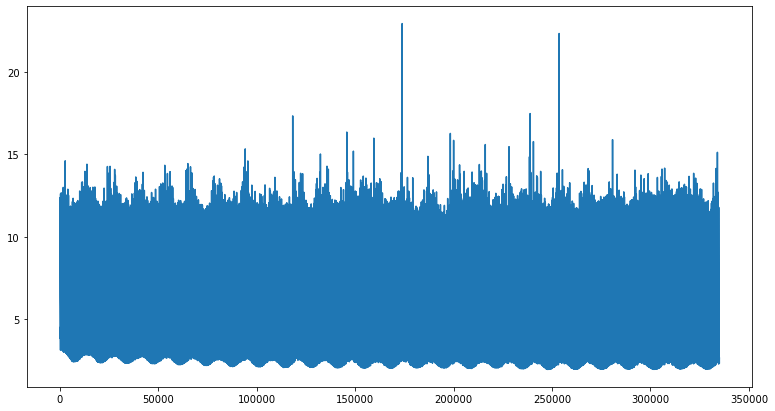

Validation loss


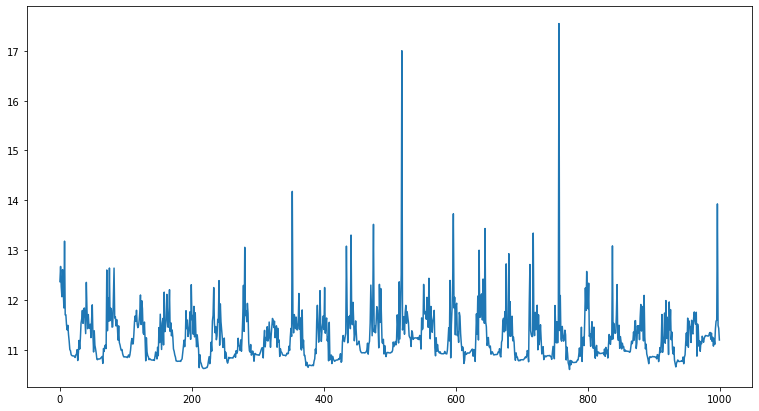

Test loss: 754.2809
--------------------------------------------------------


In [428]:
print('Train loss')
plt.plot(trl)
plt.show()
print('Validation loss')
plt.plot(vll)
plt.show()
print(f'Test loss: {test_loss.round(4)}')
print('--------------------------------------------------------')

In [429]:
## epoch에 따라 성능이 아주 조금씩 개선되는 것을 발견할 수 있음

In [448]:
df_answer = pd.concat([train_ans, valid_ans, test_ans])
df_answer["target"] = ys
df_answer['hat'] = outs
df_answer = df_answer.set_index('time')

validation


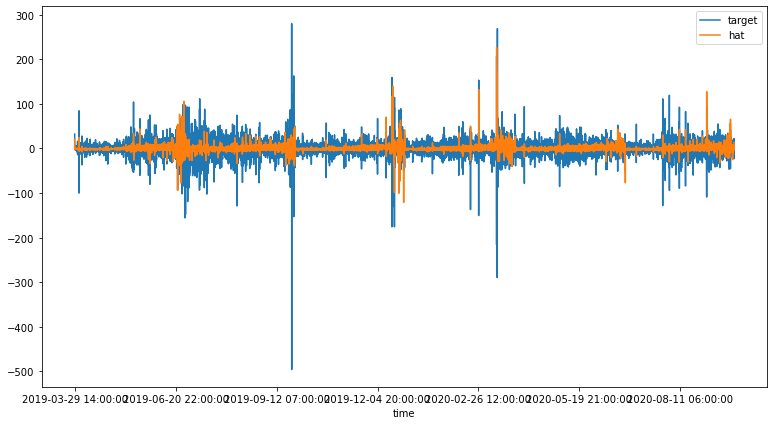

test


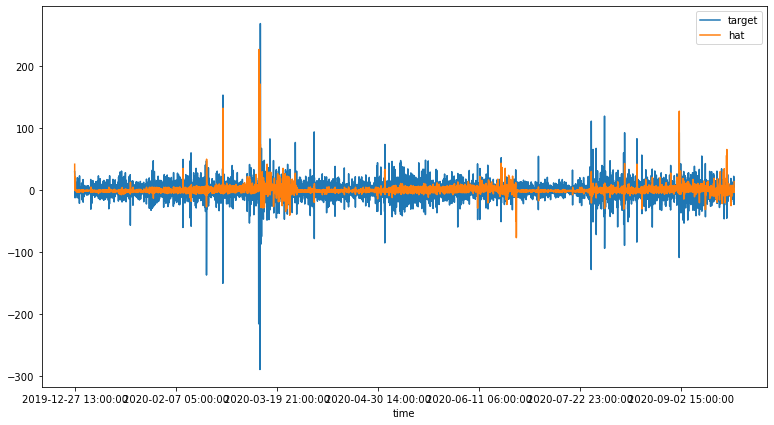

In [449]:
print("validation")
df_answer['2019-03-29 14:00:00':].plot()
plt.show()
print("test")
df_answer['2019-12-27 13:00:00':].plot()
plt.show()

In [450]:
test = df_answer['2019-12-27 13:00:00':]

In [451]:
print("승률")
(1 - len(test[(test['target'] * test['hat'])<-.1])/len(test))

승률


0.6014703629958646

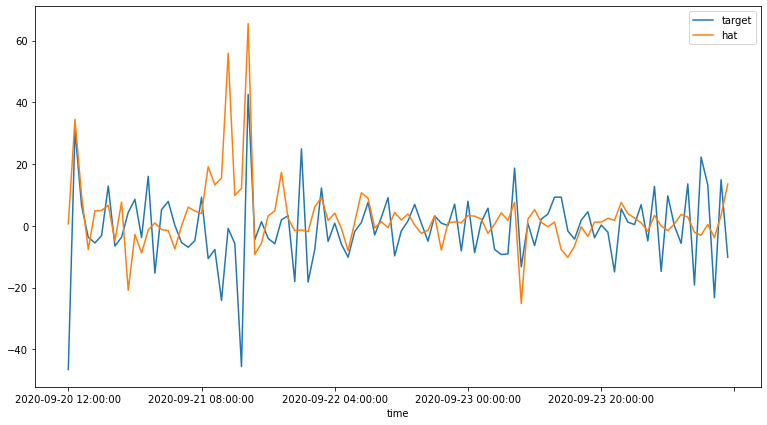

In [452]:
df_answer.tail(100).plot()
plt.show()

In [501]:
df_ori = pd.read_csv('data/data_featsel.csv', index_col=0)
result_df = df_ori.copy()
result_df['hat'] = df_answer['hat']
result_df['hat'] = result_df['spread'].shift(1) + result_df['hat']
result_df = result_df[['spread', 'hat']].dropna()

In [503]:
result_df.to_csv('data/result_GRU.csv')